# Exploratory Data Analyses

Goal:
Predict **Circulation Loss** based in Geology, Geophysics, Drilling and Reservour Engineering Studies in planning phase with the objective to choose between MPD and conventional rigs to drill the well.

In [1]:
%autosave 0

Autosave disabled


In [2]:
%matplotlib inline
import itertools
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plt
from pandas.plotting import scatter_matrix
#from customplot import *

In [3]:
# define tamanho padrão das figuras
#plt.rc('figure', figsize=(10, 5))
#fizsize_with_subplots = (10, 100)
bin_size = 10 

In [4]:
dfbase = pd.read_csv('baseProjeto_to_EDA.csv', index_col=0)
dfbase.head(5)

,AREA,POÇO,ID_INTERVALO,ATRIB_MED1,ATRIB_MAX1,ATRIB_DIST1,DIFP,PERDA_MAX,MGP1,MGP2,...,MGP8,MGP9,MGP10,MGP11,MGP12,MGP13,MGP14,Perda30,PerdaAPI,PerdaPS
1,C1,C1P1,A1,0.08,0.54,1000.0,0.61,100.0,1,1,...,1,1,1,0,0,0,0,1,1,0
2,C1,C1P1,A2,0.05,0.05,1000.0,0.54,12.0,1,1,...,1,1,1,0,0,0,0,0,0,0
3,C1,C1P1,A3,0.05,0.05,1000.0,0.61,10.0,1,1,...,1,1,1,0,0,0,0,0,0,0
4,C1,C1P1,B1,0.13,0.92,3000.0,0.63,0.0,1,1,...,1,1,1,0,0,0,0,0,0,0
5,C1,C1P2,A1,0.16,0.83,300.0,0.42,999.0,1,1,...,1,1,1,1,1,1,1,1,1,1


In [5]:
categorize = lambda x: x.astype('category')
cat = [ 'MGP1', 'MGP2', 'MGP3', 'MGP4', 'MGP5', 'MGP6', 'MGP7', 'MGP8', 
       'MGP9', 'MGP10', 'MGP11', 'MGP12', 'MGP13', 'MGP14','Perda30', 
       'PerdaAPI','PerdaPS']
dfbase[cat] = dfbase[cat].apply(categorize,axis=0)

## *Algumas estatísticas dos dados*
*apenas para dados numéricos

In [6]:
dfbase.describe()

,ATRIB_MED1,ATRIB_MAX1,ATRIB_DIST1,DIFP,PERDA_MAX
count,293.000000,293.000000,293.000000,293.000000,293.000000
mean,0.155734,0.396109,521.638601,0.939148,63.685392
std,0.163815,0.397911,415.873750,0.498942,194.792139
min,0.050000,0.050000,0.000000,0.000000,0.000000
25%,0.050000,0.050000,167.000000,0.610000,0.000000
50%,0.050000,0.100000,405.000000,0.860000,0.000000
75%,0.220000,0.920000,1000.000000,1.200000,20.000000
max,0.940000,0.950000,3000.000000,2.570000,1100.000000


The max value in `ATRIB_DIST1` look a outlier

In [7]:
print(dfbase.sort_values('ATRIB_DIST1', ascending=False).head(5)['ATRIB_DIST1'])

4      3000.0
1      1000.0
222    1000.0
207    1000.0
208    1000.0
Name: ATRIB_DIST1, dtype: float64


In this case, I am goint to substitute it using the **75%** value

In [8]:
dfbase.loc[dfbase['ATRIB_DIST1']==3000, 'ATRIB_DIST1'] = 1000

In [9]:
print(dfbase.sort_values('ATRIB_DIST1', ascending=False).head(5)['ATRIB_DIST1'])

1      1000.0
222    1000.0
207    1000.0
208    1000.0
103    1000.0
Name: ATRIB_DIST1, dtype: float64


In [10]:
dfbase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 1 to 303
Data columns (total 25 columns):
AREA            293 non-null object
POÇO            293 non-null object
ID_INTERVALO    293 non-null object
ATRIB_MED1      293 non-null float64
ATRIB_MAX1      293 non-null float64
ATRIB_DIST1     293 non-null float64
DIFP            293 non-null float64
PERDA_MAX       293 non-null float64
MGP1            293 non-null category
MGP2            293 non-null category
MGP3            293 non-null category
MGP4            293 non-null category
MGP5            293 non-null category
MGP6            293 non-null category
MGP7            293 non-null category
MGP8            293 non-null category
MGP9            293 non-null category
MGP10           293 non-null category
MGP11           293 non-null category
MGP12           293 non-null category
MGP13           293 non-null category
MGP14           293 non-null category
Perda30         293 non-null category
PerdaAPI        293 non-null cat

In [11]:
dfbase.corr(method='pearson', min_periods=1)

,ATRIB_MED1,ATRIB_MAX1,ATRIB_DIST1,DIFP,PERDA_MAX
ATRIB_MED1,1.000000,0.820445,-0.542505,-0.188305,0.115042
ATRIB_MAX1,0.820445,1.000000,-0.468389,-0.249490,0.183953
ATRIB_DIST1,-0.542505,-0.468389,1.000000,0.179799,-0.188291
DIFP,-0.188305,-0.249490,0.179799,1.000000,-0.118716
PERDA_MAX,0.115042,0.183953,-0.188291,-0.118716,1.000000


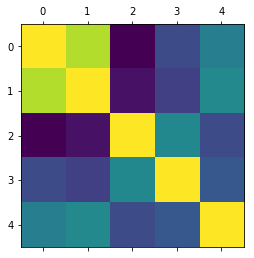

In [12]:
plt.matshow(dfbase.corr(method='pearson', min_periods=1))

## *Removendo features com alta correlação*

In [13]:
# Create correlation matrix
corr_matrix = dfbase.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [14]:
to_drop

[]

In [15]:
# Drop correlatede features 
#dfbase=dfbase.drop(to_drop, axis=1)
# Adjust y position
dftemp = dfbase[['Perda30','PerdaAPI','PerdaPS','PERDA_MAX']]
dfbase=dfbase.drop(['Perda30','PerdaAPI','PerdaPS','PERDA_MAX'], axis=1)
dfbase[['Perda30','PerdaAPI','PerdaPS','PERDA_MAX']]=dftemp[['Perda30','PerdaAPI','PerdaPS','PERDA_MAX']]

In [16]:
dfbase.head()

,AREA,POÇO,ID_INTERVALO,ATRIB_MED1,ATRIB_MAX1,ATRIB_DIST1,DIFP,MGP1,MGP2,MGP3,...,MGP9,MGP10,MGP11,MGP12,MGP13,MGP14,Perda30,PerdaAPI,PerdaPS,PERDA_MAX
1,C1,C1P1,A1,0.08,0.54,1000.0,0.61,1,1,1,...,1,1,0,0,0,0,1,1,0,100.0
2,C1,C1P1,A2,0.05,0.05,1000.0,0.54,1,1,1,...,1,1,0,0,0,0,0,0,0,12.0
3,C1,C1P1,A3,0.05,0.05,1000.0,0.61,1,1,1,...,1,1,0,0,0,0,0,0,0,10.0
4,C1,C1P1,B1,0.13,0.92,1000.0,0.63,1,1,1,...,1,1,0,0,0,0,0,0,0,0.0
5,C1,C1P2,A1,0.16,0.83,300.0,0.42,1,1,1,...,1,1,1,1,1,1,1,1,1,999.0


In [17]:
dfbase.corr(method='pearson', min_periods=1).columns

Index(['ATRIB_MED1', 'ATRIB_MAX1', 'ATRIB_DIST1', 'DIFP', 'PERDA_MAX'], dtype='object')

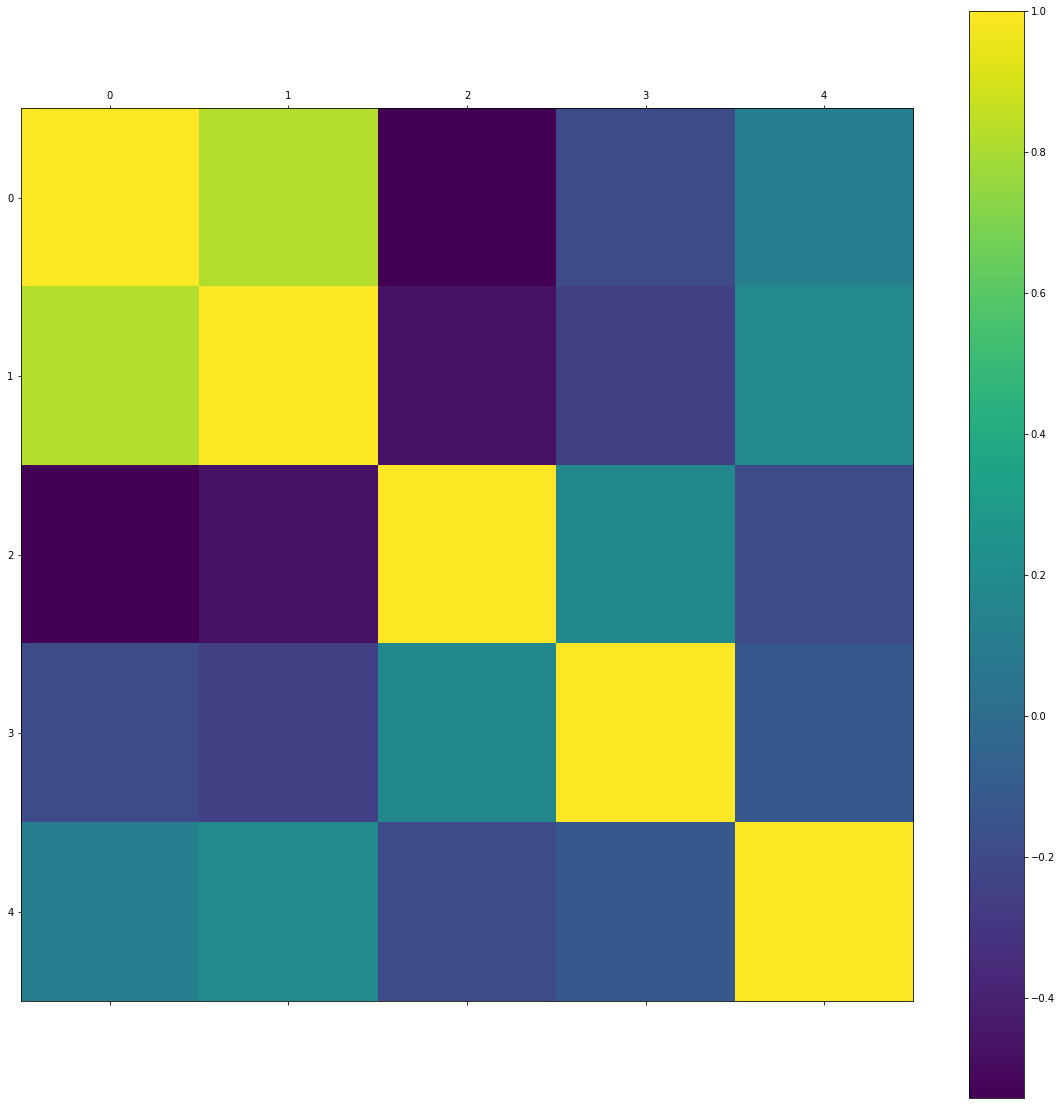

In [18]:
plt.rc('figure', figsize=(20, 20))
#fizsize_with_subplots = (100, 200)
#alpha = dfbase.corr(method='pearson', min_periods=1).columns

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dfbase.corr(method='pearson', min_periods=1))
fig.colorbar(cax)

#ax.set_xticklabels(alpha)
#ax.set_yticklabels(alpha)

plt.show()


## *Verificando outliers*

In [19]:
x=dfbase.describe().columns # Obtaining the columns

In [20]:
#dfbase.info()

In [21]:
numbers = ['ATRIB_MED1', 'ATRIB_MAX1', 'ATRIB_DIST1', 'DIFP']
categorics = ['MGP1', 'MGP2',
       'MGP3', 'MGP4', 'MGP5', 'MGP6', 'MGP7', 'MGP8', 'MGP9', 'MGP10',
       'MGP11', 'MGP12', 'MGP13', 'MGP14']
y = ['Perda30']

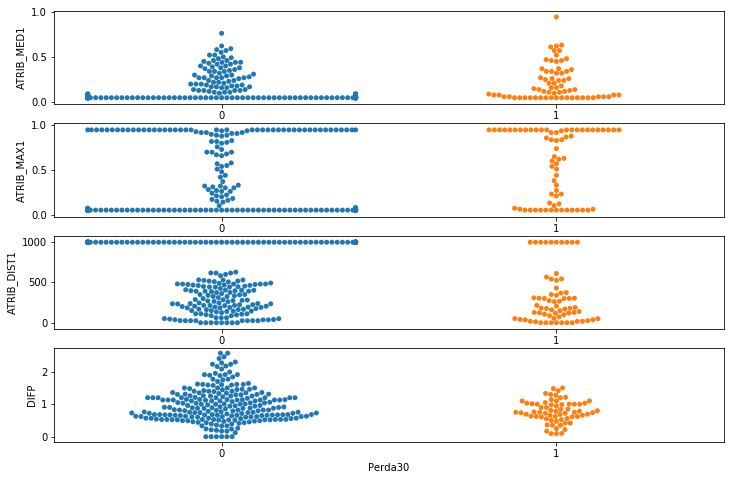

In [22]:
fig_size=plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.figure(1)
a=1
for i in numbers:
    plt.subplot(len(x),1,a) #subplot(nrows, ncols, index, **kwargs)
    sns.swarmplot(x='Perda30', y=i, data=dfbase)
    a+=1
plt.show()


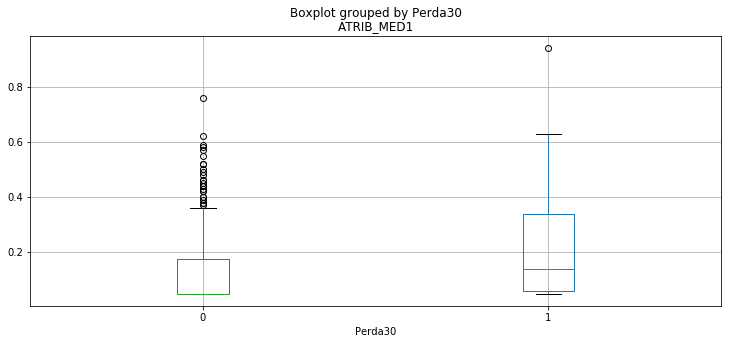

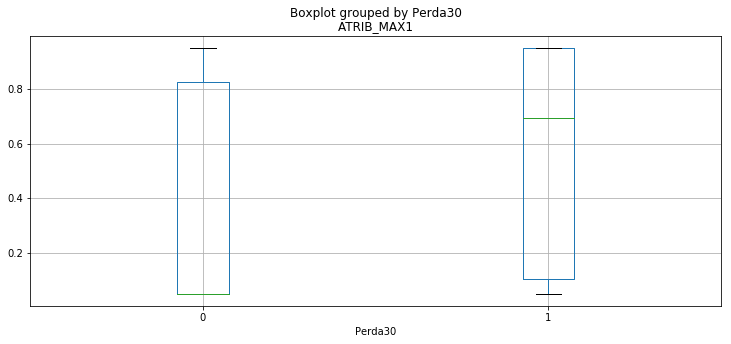

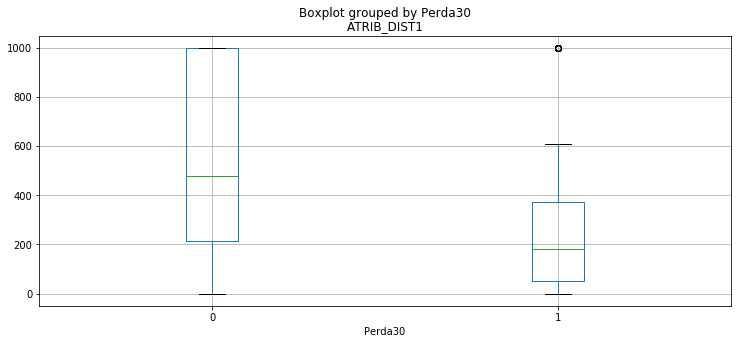

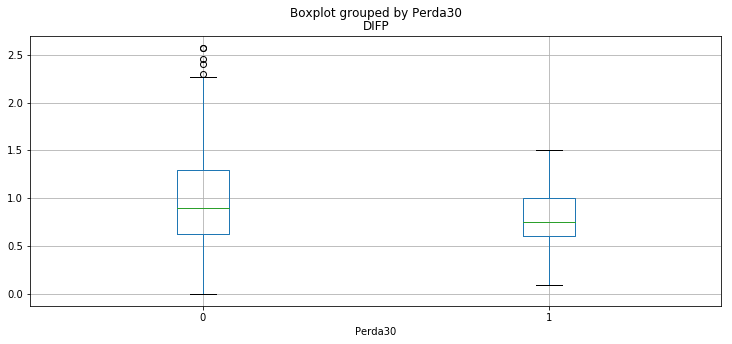

In [23]:
fig_size[0] = 12
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
for i in numbers:
    dfbase.boxplot(column=i, by='Perda30')

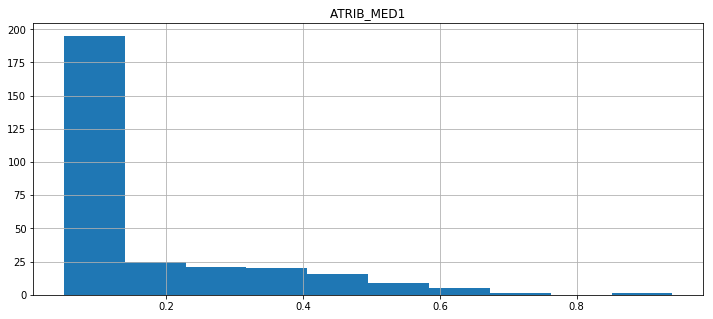

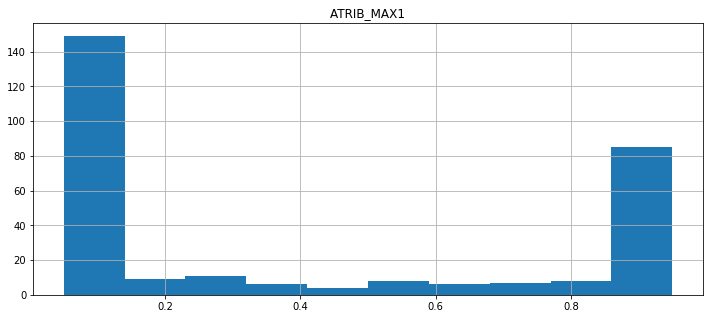

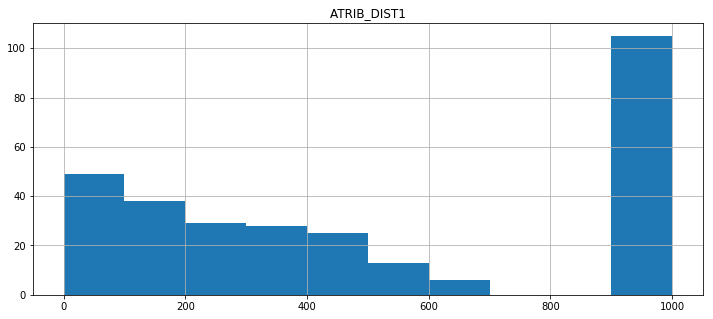

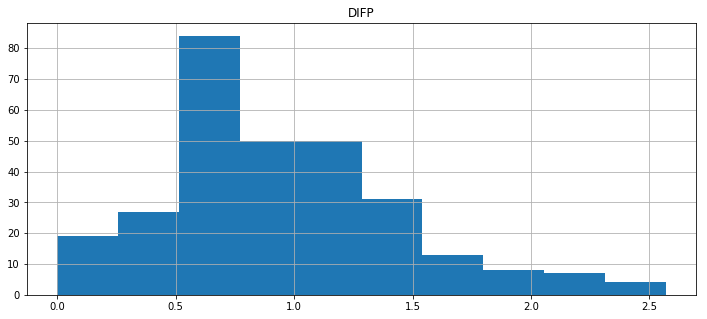

In [24]:
for i in numbers:
    dfbase.hist(column=i)

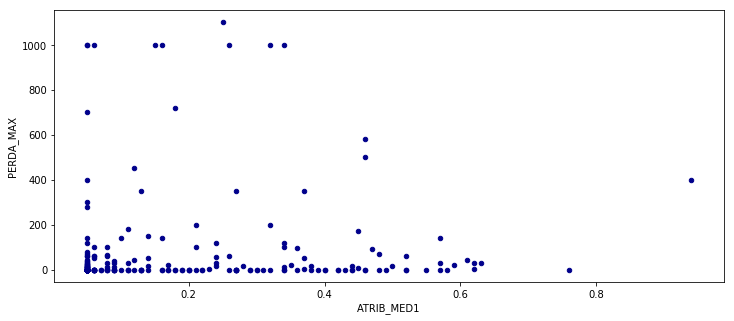

In [25]:
ax1 = dfbase.plot.scatter(x='ATRIB_MED1', y='PERDA_MAX', c='DarkBlue')

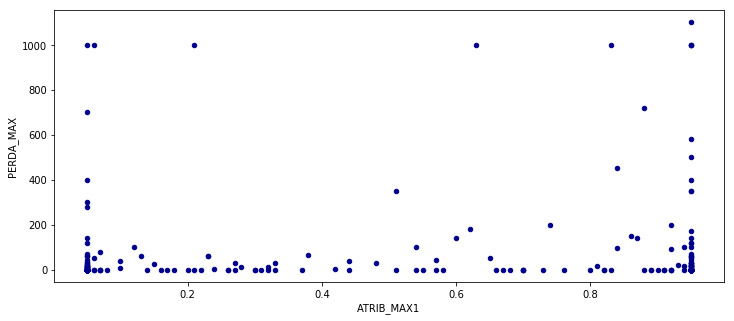

In [26]:
ax1 = dfbase.plot.scatter(x='ATRIB_MAX1', y='PERDA_MAX', c='DarkBlue')

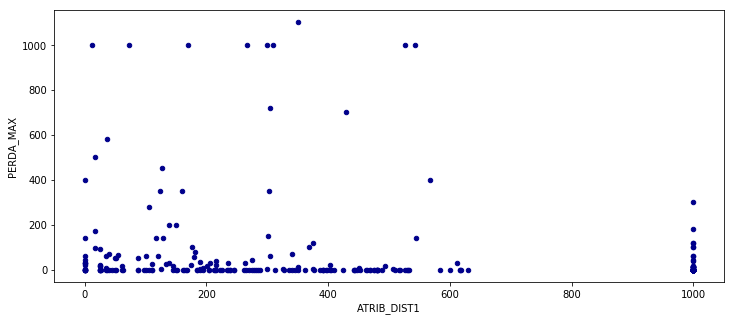

In [27]:
ax1 = dfbase.plot.scatter(x='ATRIB_DIST1', y='PERDA_MAX', c='DarkBlue')

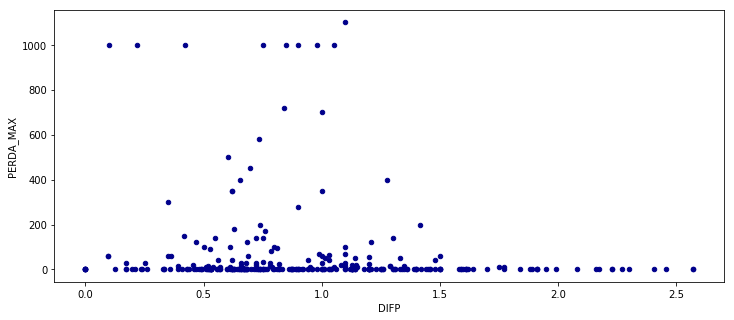

In [28]:
ax1 = dfbase.plot.scatter(x='DIFP', y='PERDA_MAX', c='DarkBlue')

In [29]:
#sns.pairplot(dfbase)
#plt.show()

In [30]:
dfbase.to_csv('baseProjeto_entradaModelo.csv', encoding='utf-8')